<a href="https://colab.research.google.com/github/MohammadRaziei/FMRI-ANS-SUT/blob/master/PYMVPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Multivariate Pattern Analysis Package on Google Colab

## Preface

### Download required files

Run the cell bellow to download dataset and distribitubale library form for colab:

In [ ]:
!pip install wget
!pip install duecredit
!pip install nibabel==2.5.2


import wget
import tarfile


wget.download('https://github.com/HNXJ/AdvNeuroscience/raw/master/mvpa.zip')
f = [wget.download('http://data.pymvpa.org/datasets/haxby2001/stimuli-2010.01.14.tar.gz')]
for i in range(1, 7):
  f.append(wget.download('http://data.pymvpa.org/datasets/haxby2001/subj' + str(i) + '-2010.01.14.tar.gz'))


### Extract files

In [ ]:
!mkdir mvpa2
from zipfile import ZipFile 
import tarfile
import os


def extract_zipfile(fname, path):
  with ZipFile(fname, 'r') as zip: 
    # zip.printdir() 
    print('Extracting zip file : ' + fname + ' ...') 
    zip.extractall(path) 
    print('Done!') 
    return


def extract_tarfile(fname, path):
  with tarfile.open(fname, "r:gz") as tar:
    print('Extracting tar file : ' + fname + ' ...') 
    tar.extractall(path)
    print('Done!') 
    return


file_name = "mvpa.zip"  
folder_path1 = 'datadb/haxby2001/'
folder_path2 = 'mvpa2/'
cnt = 0

extract_zipfile(fname=file_name, path=folder_path2)
for fname in f:
  cnt += 1
  extract_tarfile(fname=fname, path=folder_path1)

mkdir: cannot create directory ‘mvpa2’: File exists
Extracting zip file : mvpa.zip ...
Done!
Extracting tar file : stimuli-2010.01.14.tar (1).gz ...
Done!
Extracting tar file : subj1-2010.01.14.tar (1).gz ...
Done!
Extracting tar file : subj2-2010.01.14.tar (1).gz ...
Done!
Extracting tar file : subj3-2010.01.14.tar (1).gz ...
Done!
Extracting tar file : subj4-2010.01.14.tar (1).gz ...
Done!
Extracting tar file : subj5-2010.01.14.tar (1).gz ...
Done!
Extracting tar file : subj6-2010.01.14.tar (1).gz ...


### Library test: load dataset

If you got "logsumexp ImportError" try this:

Change from "scipy.misc import logsumexp" to "from scipy.special import logsumexp" in error file (probably "infotheo.py").

In [ ]:
from mvpa2.suite import *


subjpath = os.path.join(pymvpa_datadbroot, 'haxby2001', 'subj1')
attrs = SampleAttributes(os.path.join(subjpath, 'labels.txt'),
                          header=True)
ds = fmri_dataset(samples=os.path.join(subjpath, 'bold.nii.gz'),
                   targets=attrs.labels, chunks=attrs.chunks,
                   mask=os.path.join(subjpath, 'mask4_vt.nii.gz'))

print(ds.O.shape)

## Visualize example

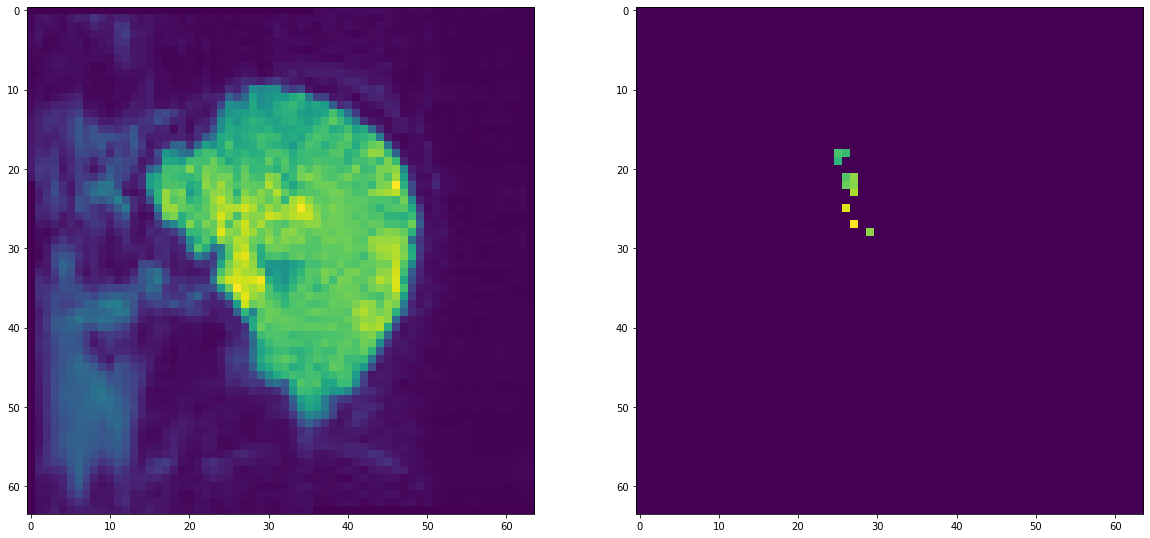

In [ ]:
import os, logging
from mvpa2.suite import *
from matplotlib import pyplot as plt 


logging.getLogger("imported_module").setLevel(logging.ERROR)
# subjpath = os.path.join(pymvpa_datadbroot, 'haxby2001', 'subj1')

print("="*30)
subjpath = os.path.join(os.getcwd(),'datadb', 'haxby2001', 'subj1')
attrs = SampleAttributes(os.path.join(subjpath, 'labels.txt'),
                         header=True)

ds1 = fmri_dataset(samples=os.path.join(subjpath, 'bold.nii.gz'),
                  targets=attrs.labels, chunks=attrs.chunks,
                  mask=None)
                  # mask=os.path.join(subjpath, 'mask4_vt.nii.gz'))

ds2 = fmri_dataset(samples=os.path.join(subjpath, 'bold.nii.gz'),
                  targets=attrs.labels, chunks=attrs.chunks,
                  # mask=None)
                  mask=os.path.join(subjpath, 'mask4_vt.nii.gz'))

# Sample plots
fig, ax = plt.subplots(1, 2, figsize=(20, 35))
ax[0].imshow(ds1.O[1, 25, :, :])
ax[1].imshow(ds2.O[1, 25, :, :])
fig.show()

## Correlation example

In [ ]:
from mvpa2.measures.corrcoef import pearson_correlation


def normalize(x):
    x = (x - np.min(x))/np.std(x)
    return x


def get_label_dict():
  labels = []
  cats = {}
  with open(os.path.join(subjpath,'labels.txt'), 'r') as f:
      f.readline()
      for i in range(1452):
          s = f.readline().split(' ')
          labels.append((s[0],int(s[1])))
          try:
              cats[s[0]].append(i)
          except:
              cats[s[0]] = [i]
  return labels, cats


def get_corr(cat1, cat2, ds, cats, xx=5, yy=5, maximall_exclude=True):
  corr = np.zeros([xx, yy])
  for i in range(xx):
    for j in range(yy):
      X = ds.O[cats[cat1][i],:,:,:].reshape(-1, 1) - z
      Y = ds.O[cats[cat2][j],:,:,:].reshape(-1, 1) - z
      z = np.mean(ds.O, axis=0).reshape(-1, 1)
      # z = np.mean(ds.O[cats[cat1][i],:,:,:], axis=0).reshape(-1, 1)
      
      if maximall_exclude:
        z = np.where(z < np.max(z)*0.9)[0]
        X = X[z]
        Y = Y[z]
      
      z = np.union1d( np.where(X > 0)[0], np.where(Y > 0)[0])
      X = normalize(X[z])
      Y = normalize(Y[z])

      corr[i, j] = pearson_correlation(X, Y)
  return corr


def show_colormap_corr(ax, cat1, cat2, ds, xx=5, yy=5, maximall_exclude=True):
  labels, cats = get_label_dict()
  corr = get_corr(cat1=cat1, cat2=cat2, ds=ds, cats=cats, xx=xx, yy=yy, maximall_exclude=maximall_exclude)
  im = ax.imshow(corr, interpolation='None')

  ax.set_title("Correlations between " + cat1 + " and " + cat2)
  ax.set_ylabel(cat1)
  ax.set_xlabel(cat2)
  plt.colorbar(im, ax=ax)
  return


def overall_corr(cat1, cat2, ds, xx=5, yy=5, maximall_exclude=True):
  labels, cats = get_label_dict()
  corr = get_corr(cat1=cat1, cat2=cat2, ds=ds, cats=cats, xx=xx, yy=yy, maximall_exclude=maximall_exclude)
  return np.mean(corr)

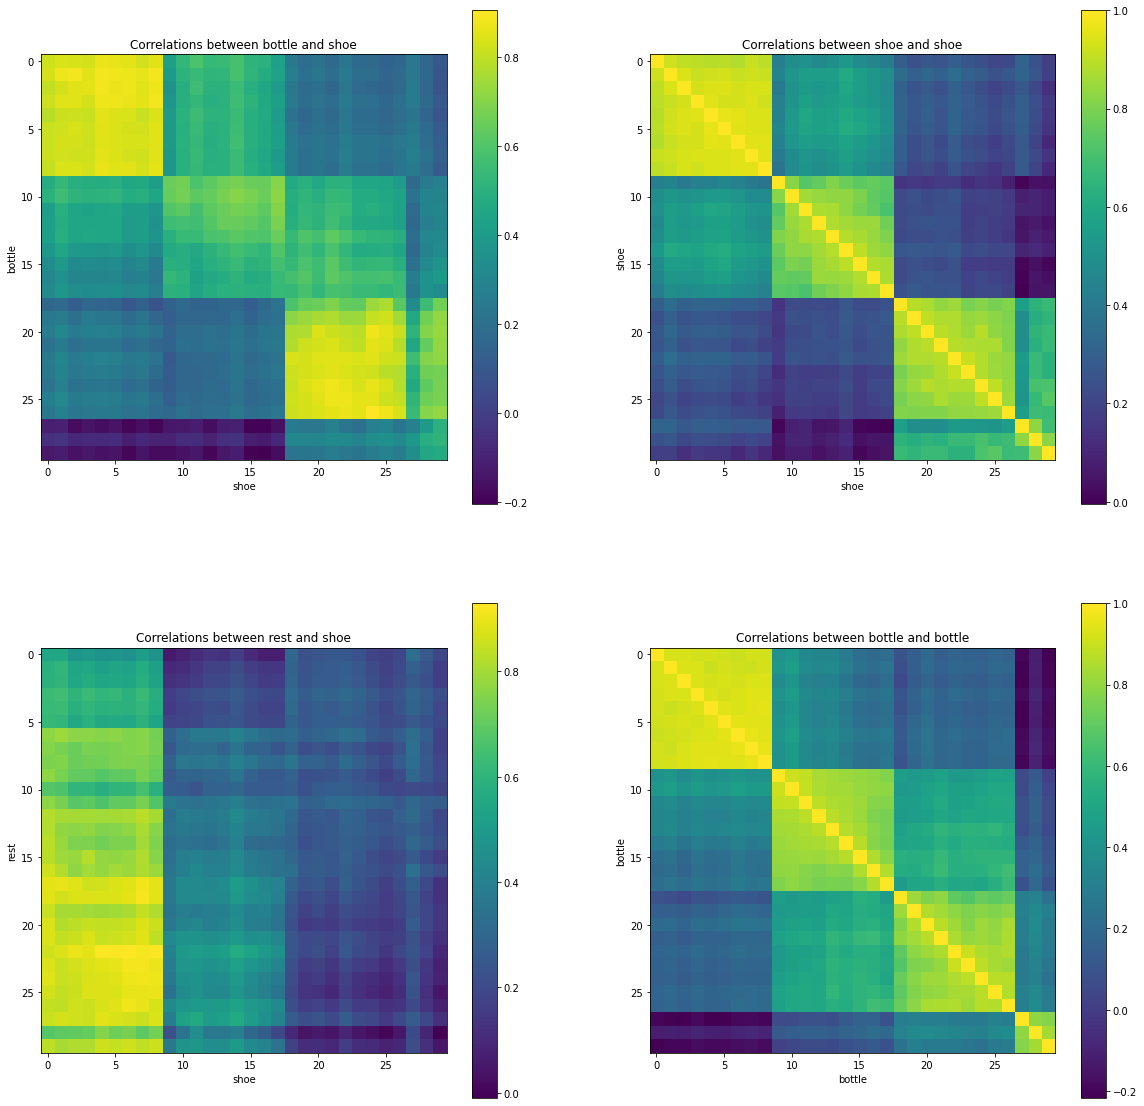

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
x, y = 30, 30

show_colormap_corr(ax=ax[0, 0], cat1="bottle", cat2="shoe", ds=ds, xx=x, yy=y)
show_colormap_corr(ax=ax[0, 1], cat1="shoe", cat2="shoe", ds=ds, xx=x, yy=y)
show_colormap_corr(ax=ax[1, 0], cat1="rest", cat2="shoe", ds=ds, xx=x, yy=y)
show_colormap_corr(ax=ax[1, 1], cat1="bottle", cat2="bottle", ds=ds, xx=x, yy=y)

fig.show()

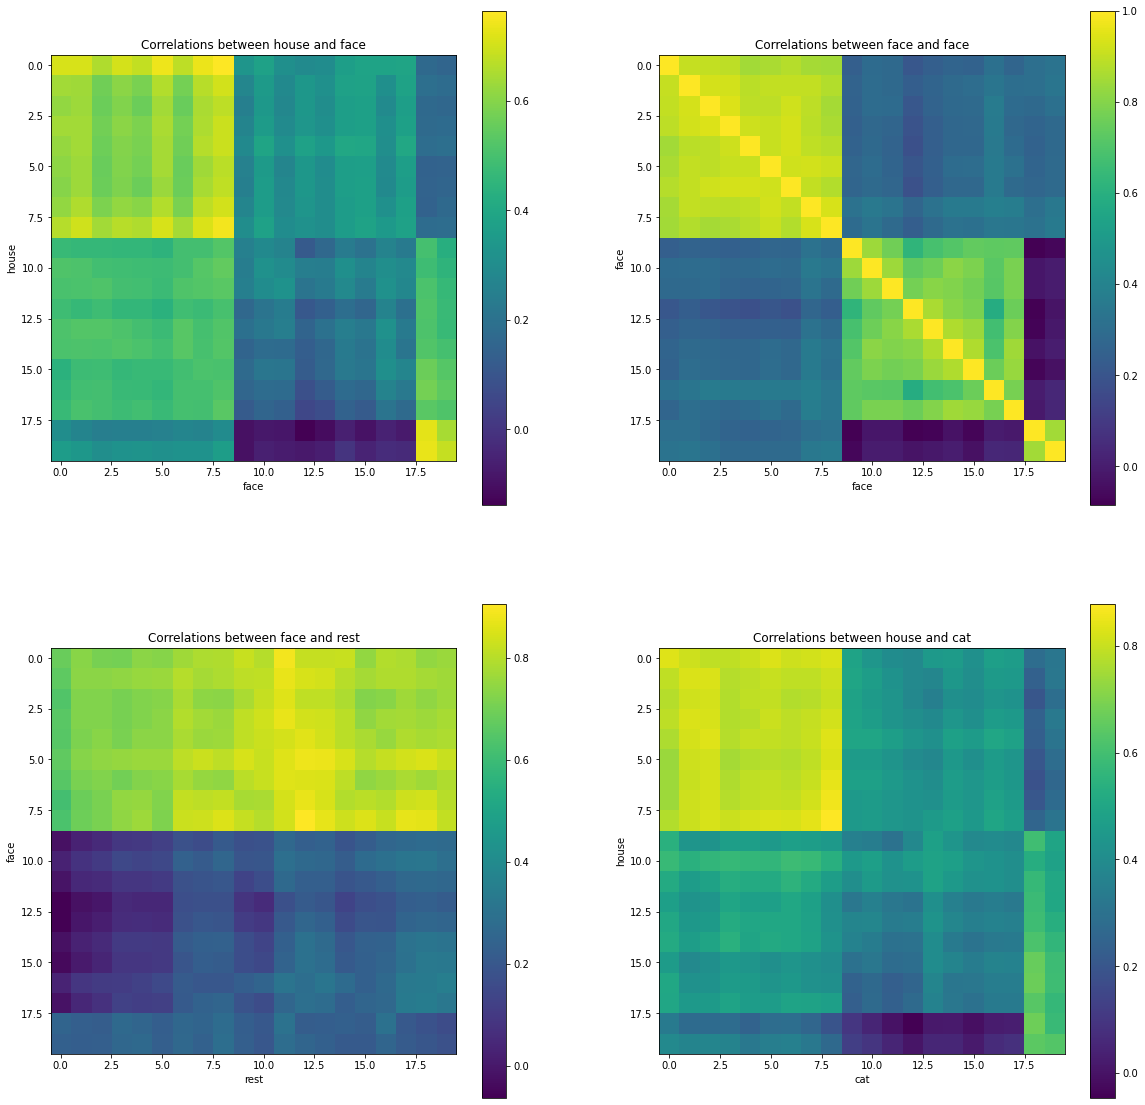

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
x, y = 20, 20

show_colormap_corr(ax=ax[0, 0], cat1="house", cat2="face", ds=ds, xx=x, yy=y)
show_colormap_corr(ax=ax[0, 1], cat1="face", cat2="face", ds=ds, xx=x, yy=y)
show_colormap_corr(ax=ax[1, 0], cat1="face", cat2="rest", ds=ds, xx=x, yy=y)
show_colormap_corr(ax=ax[1, 1], cat1="house", cat2="cat", ds=ds, xx=x, yy=y)

fig.show()

# Within and between category correlations

...

In [ ]:
Corrs = np.zeros([7, 7, 2])
labels, cats = get_label_dict()
cts = cats.keys()

for i in range(7):
  for j in range(7):
    Corrs[i, j, 0] = overall_corr(cat1=cts[i], cat2=cts[j], ds=ds, xx=24, yy=24, maximall_exclude=True)
    Corrs[i, j, 1] = overall_corr(cat1=cts[i], cat2=cts[j], ds=ds, xx=24, yy=24, maximall_exclude=False)

fig, ax = plt.subplots(1, 2, figsize=(15, 28))

im = ax[0].imshow(Corr[:, :, 0], interpolation='None')
ax[0].set_title("All voxel correlations")
plt.colorbar(im, ax=ax[0])

im = ax[1].imshow(Corr[:, :, 1], interpolation='None')
ax[1].set_title("Maximally excluded voxels correlations")
plt.colorbar(im, ax=ax[1])

fig.show()